In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
audio_files_dir = '/content/gdrive/My Drive/UpworkNotebooks/Opera Files/'

!ls -ltra '{audio_files_dir}'/.

Mounted at /content/gdrive
ls: '/content/gdrive/My Drive/UpworkNotebooks/Opera Files//./Audios': No such file or directory
total 31
lrw------- 1 root root    0 May  1 02:47 Audios -> /content/gdrive/.shortcut-targets-by-id/1DOvML8hO7v6XEq5-HQAQSvo7eKca7tSf/Audios
drwx------ 2 root root 4096 Sep 12 11:40 New_male_only_200_each
drwx------ 2 root root 4096 Sep 22 14:29 All_Data
drwx------ 2 root root 4096 Sep 22 14:40 Keras_Tuner_Logs
drwx------ 2 root root 4096 Sep 22 14:57 Documentation
drwx------ 2 root root 4096 Sep 22 15:02 Helper_Notebooks
drwx------ 2 root root 4096 Sep 22 15:03 Csv_Files
drwx------ 2 root root 4096 Sep 22 15:05 Main_Notebooks
-rw------- 1 root root  593 Oct 20 13:14 lol.png
-rw------- 1 root root  593 Oct 20 13:14 lol2.png
-rw------- 1 root root  974 Oct 20 13:22 lol3.png


In [ ]:
!pip install -q tensorflow_io

     |████████████████████████████████| 22.7 MB 110.4 MB/s 
     |████████████████████████████████| 2.3 MB 53.5 MB/s 


In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

import librosa

In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
data = pd.read_csv(audio_files_dir + 'file_paths.csv')
data = data.sample(frac=1) 
data['fold'] = [0]*int(0.6*(len(data))) + [1]*int(0.2*(len(data))) + [2]*int(0.2*(len(data)))
data.head()


,path,subregister,Target,fold
2133,/content/gdrive/My Drive/UpworkNotebooks/Opera...,Soprano_Coloratura,13,0
1341,/content/gdrive/My Drive/UpworkNotebooks/Opera...,Baritones_BassBaritone,8,0
867,/content/gdrive/My Drive/UpworkNotebooks/Opera...,Tenor_Leggero,5,0
310,/content/gdrive/My Drive/UpworkNotebooks/Opera...,New Countertenor,1,0
1151,/content/gdrive/My Drive/UpworkNotebooks/Opera...,Tenor_Spinto,7,0


In [ ]:
@tf.function
def load_wav_16k_mono(filename):
  """ read in a waveform file and convert to 16 kHz mono """
  # filename = filename.numpy().decode('utf-8')
  # print(filename)
  wav, sample_rate = librosa.load(filename)
  sample_rate = tf.cast(sample_rate, dtype=tf.int64)
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  # return wav
  return wav


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


tf.Tensor(
[ 8.4357470e-07 -1.4618876e-06  1.6473360e-06 ... -5.0561182e-02
 -5.2385096e-02 -5.7129994e-02], shape=(96000,), dtype=float32)


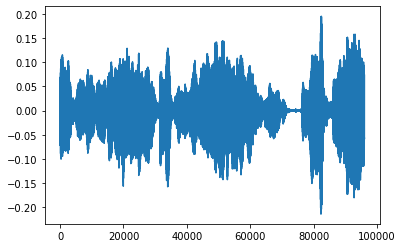

In [ ]:

testing_wav_file_name = data['path'][0]
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)
print(testing_wav_data)
plt.figure()
plt.plot(testing_wav_data)

In [ ]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
infered_class = class_names[top_class]

print(f'The main sound is: {infered_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Singing
The embeddings shape: (12, 1024)


In [ ]:
filenames = data['path']
targets = data['Target']
folds = data['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

# for x, y, z in main_ds:
#   print(type(x.numpy().decode('utf-8')))
#   a = x.numpy().decode('utf-8')
#   print(x.numpy().decode('utf-8'))
#   print(load_wav_16k_mono(a))
#   print(x)
#   print(y)
#   print(z)
#   break

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
def load_wav_for_map(filename, label, fold):
  filename = filename.numpy().decode('utf-8')
  return load_wav_16k_mono(filename), label, fold

# main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

k_mono = [load_wav_16k_mono(filename.numpy().decode('utf-8')) for filename, label, fold in main_ds]
  # a = x.numpy().decode('utf-8')
  # print(x.numpy().decode('utf-8'))
  # print(load_wav_16k_mono(a))
  # print(x)
  # print(y)
  # print(z)
  # break

/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: PySoundFile failed. Trying audioread instead.
  return py_builtins.overload_of(f)(*args)


In [ ]:
main_ds = tf.data.Dataset.from_tensor_slices((k_mono, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(96000,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold == 0)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 1)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 2)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(1).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(1).prefetch(tf.data.AUTOTUNE)

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(18)
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 18)                9234      
Total params: 534,034
Trainable params: 534,034
Non-trainable params: 0
_________________________________________________________________


In [ ]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
history = my_model.fit(train_ds, epochs=700, steps_per_epoch=3, validation_data=val_ds)

Epoch 1/700
3/3 [==============================] - 46s 1s/step - loss: 2.8968 - accuracy: 0.0625 - val_loss: 2.9790 - val_accuracy: 0.0549
Epoch 2/700
3/3 [==============================] - 2s 1s/step - loss: 2.8888 - accuracy: 0.0729 - val_loss: 3.0253 - val_accuracy: 0.0572
Epoch 3/700
3/3 [==============================] - 2s 1s/step - loss: 2.8940 - accuracy: 0.1250 - val_loss: 3.0579 - val_accuracy: 0.0580
Epoch 4/700
3/3 [==============================] - 2s 1s/step - loss: 2.9407 - accuracy: 0.0417 - val_loss: 3.0663 - val_accuracy: 0.0568
Epoch 5/700
3/3 [==============================] - 2s 1s/step - loss: 2.9172 - accuracy: 0.0938 - val_loss: 3.0777 - val_accuracy: 0.0501
Epoch 6/700
3/3 [==============================] - 2s 1s/step - loss: 2.9598 - accuracy: 0.0417 - val_loss: 3.0731 - val_accuracy: 0.0590
Epoch 7/700
3/3 [==============================] - 2s 1s/step - loss: 2.9896 - accuracy: 0.0417 - val_loss: 3.0434 - val_accuracy: 0.0559
Epoch 8/700
3/3 [================

KeyboardInterrupt: ignored

In [ ]:
def model_performance(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()
  pass

model_performance(history)